# Perform Experiments with DeepFace on LFW dataset

In [14]:
# built-in dependencies
import os

# 3rd party dependencies
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_lfw_pairs
from deepface import DeepFace

In [15]:
print(f"This experiment is done with pip package of deepface with {DeepFace.__version__} version")

This experiment is done with pip package of deepface with 0.0.91 version


### Configuration Sets

In [16]:
# all configuration alternatives for 4 dimensions of arguments
alignment  = [True, False]
# models = ["Facenet512", "Facenet", "VGG-Face", "ArcFace", "Dlib", "GhostFaceNet", "SFace", "OpenFace", "DeepFace", "DeepID"]
models = ["ElasticFace_Arc", "ElasticFace_Cos", "ElasticFace_Arc+", "ElasticFace_Cos+"]
detectors = ["retinaface", "mtcnn", "fastmtcnn", "yolov8", "yunet", "centerface", "mediapipe", "ssd", "opencv", "skip"]
# detectors = ["opencv"]
metrics = ["euclidean", "euclidean_l2", "cosine"]
# metrics = ["cosine"]
expand_percentage = 0

### Create Required Folders if necessary

In [17]:
target_paths = ["lfwe", "dataset", "outputs", "outputs/test", "results"]
for target_path in target_paths:
    if os.path.exists(target_path) != True:
        os.mkdir(target_path)
        print(f"{target_path} is just created")

### Load LFW Dataset

In [18]:
pairs_touch = "outputs/test_lfwe.txt"
instances = 1000 #pairs.shape[0]

In [19]:
target_path = "dataset/test_lfw.npy"
labels_path = "dataset/test_labels.npy"

if os.path.exists(target_path) != True:
    fetch_lfw_pairs = fetch_lfw_pairs(subset = 'test', color = True
                                  , resize = 2
                                  , funneled = False
                                  , slice_=None
                                 )
    pairs = fetch_lfw_pairs.pairs
    labels = fetch_lfw_pairs.target
    target_names = fetch_lfw_pairs.target_names
    np.save(target_path, pairs)
    np.save(labels_path, labels)
else:
    if os.path.exists(pairs_touch) != True:
        # loading pairs takes some time. but if we extract these pairs as image, no need to load it anymore
        pairs = np.load(target_path)
    labels = np.load(labels_path)    

### Save LFW image pairs into file system

In [20]:
### Save LFW image pairs into file system

### Perform Experiments

This block will save the experiments results in outputs folder

In [24]:
img1_target = f"lfwe/test/{i}_1.jpg"
type(img1_target)

str

In [8]:
for model_name in models:
    for detector_backend in detectors:
        for distance_metric in metrics:
            for align in alignment:
                
                if detector_backend == "skip" and align is True:
                    # Alignment is not possible for a skipped detector configuration
                    continue
                
                alignment_text = "aligned" if align is True else "unaligned"
                task = f"{model_name}_{detector_backend}_{distance_metric}_{alignment_text}"
                output_file = f"outputs/test/{task}.csv"
                if os.path.exists(output_file) is True:
                     #print(f"{output_file} is available already")
                     continue
                
                distances = []
                for i in tqdm(range(0, instances), desc = task):
                    img1_target = f"lfwe/test/{i}_1.jpg"
                    img2_target = f"lfwe/test/{i}_2.jpg"
                    result = DeepFace.verify(
                        img1_path=img1_target,
                        img2_path=img2_target,
                        model_name=model_name,
                        detector_backend=detector_backend,
                        distance_metric=distance_metric,
                        align=align,
                        enforce_detection=False,
                        expand_percentage=expand_percentage,
                    )
                    distance = result["distance"]
                    distances.append(distance)
                # -----------------------------------
                df = pd.DataFrame(list(labels), columns = ["actuals"])
                df["distances"] = distances
                df.to_csv(output_file, index=False)

### Calculate Results

Experiments were responsible for calculating distances. We will calculate the best accuracy scores in this block.

In [9]:
data = [[0 for _ in range(len(models))] for _ in range(len(detectors))]
base_df = pd.DataFrame(data, columns=models, index=detectors)

In [12]:
for is_aligned in alignment:
    for distance_metric in metrics:

        current_df = base_df.copy()

        target_file = f"results/pivot_{distance_metric}_with_alignment_{is_aligned}.csv"
        if os.path.exists(target_file):
            continue

        for model_name in models:
            threshold_col = f"threshold_{model_name}"
            current_df[threshold_col] = 0.0  # Initialize the threshold column

            for detector_backend in detectors:

                align = "aligned" if is_aligned is True else "unaligned"

                if detector_backend == "skip" and is_aligned is True:
                    # Alignment is not possible for a skipped detector configuration
                    align = "unaligned"

                source_file = f"outputs/test/{model_name}_{detector_backend}_{distance_metric}_{align}.csv"
                if not os.path.exists(source_file):
                    print(f"File not found: {source_file}, skipping.")
                    continue

                df = pd.read_csv(source_file)

                positive_mean = df[(df["actuals"] == True) | (df["actuals"] == 1)]["distances"].mean()
                negative_mean = df[(df["actuals"] == False) | (df["actuals"] == 0)]["distances"].mean()

                distances = sorted(df["distances"].values.tolist())

                items = []
                for i, distance in enumerate(distances):
                    if distance >= positive_mean and distance <= negative_mean:
                        sandbox_df = df.copy()
                        sandbox_df["predictions"] = False
                        idx = sandbox_df[sandbox_df["distances"] < distance].index
                        sandbox_df.loc[idx, "predictions"] = True

                        actuals = sandbox_df.actuals.values.tolist()
                        predictions = sandbox_df.predictions.values.tolist()
                        accuracy = 100 * accuracy_score(actuals, predictions)
                        items.append((distance, accuracy))

                pivot_df = pd.DataFrame(items, columns=["distance", "accuracy"])
                pivot_df = pivot_df.sort_values(by=["accuracy"], ascending=False)
                threshold = pivot_df.iloc[0]["distance"]
                print(f"threshold for {model_name}/{detector_backend} is {threshold}")
                accuracy = pivot_df.iloc[0]["accuracy"]

                current_df.at[detector_backend, model_name] = round(accuracy, 1)
                current_df.at[detector_backend, threshold_col] = round(threshold, 4)

        current_df.to_csv(target_file)
        print(f"{target_file} saved")

threshold for ElasticFace_Arc/retinaface is 24.569140808038643
threshold for ElasticFace_Arc/mtcnn is 24.89160039839749
threshold for ElasticFace_Arc/fastmtcnn is 24.32011016815278
threshold for ElasticFace_Arc/yolov8 is 23.72727523479436
threshold for ElasticFace_Arc/yunet is 25.81997807788569
threshold for ElasticFace_Arc/centerface is 25.89900545742134
threshold for ElasticFace_Arc/mediapipe is 19.07661835449283
threshold for ElasticFace_Arc/ssd is 25.160918012606707
threshold for ElasticFace_Arc/opencv is 26.08768833078389
threshold for ElasticFace_Arc/skip is 20.245673073006127
threshold for ElasticFace_Cos/retinaface is 25.42256529431825
threshold for ElasticFace_Cos/mtcnn is 26.615099169039524
threshold for ElasticFace_Cos/fastmtcnn is 26.15686429513148
threshold for ElasticFace_Cos/yolov8 is 25.06901281129512
threshold for ElasticFace_Cos/yunet is 26.13245209152013
threshold for ElasticFace_Cos/centerface is 26.79005756302132
threshold for ElasticFace_Cos/mediapipe is 20.436390

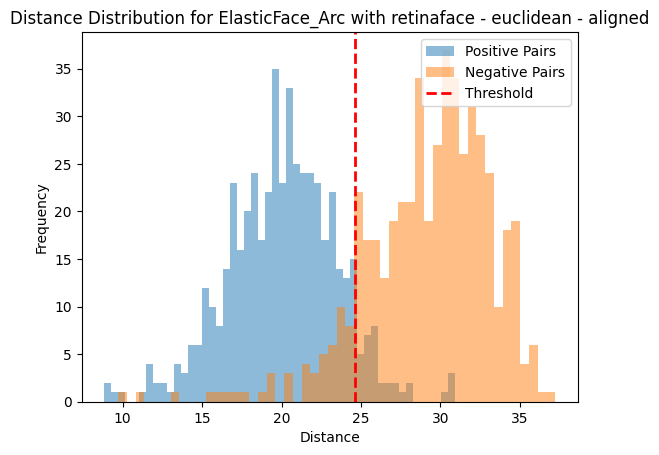

False Positives: 53
False Negatives: 35


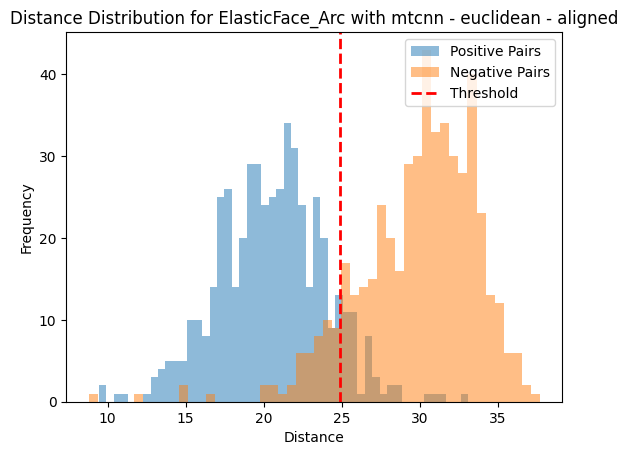

False Positives: 48
False Negatives: 45


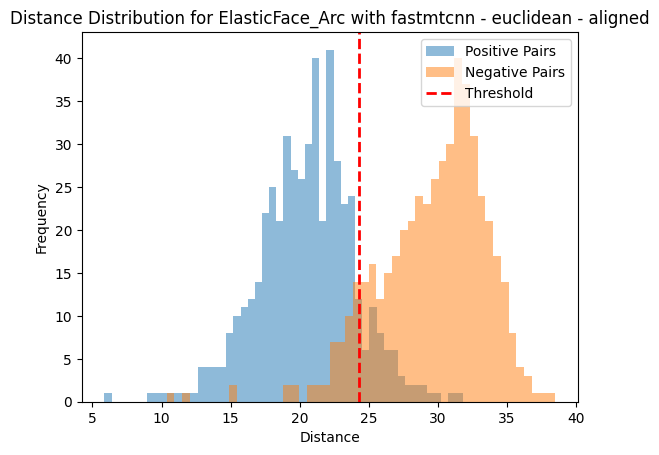

False Positives: 46
False Negatives: 55


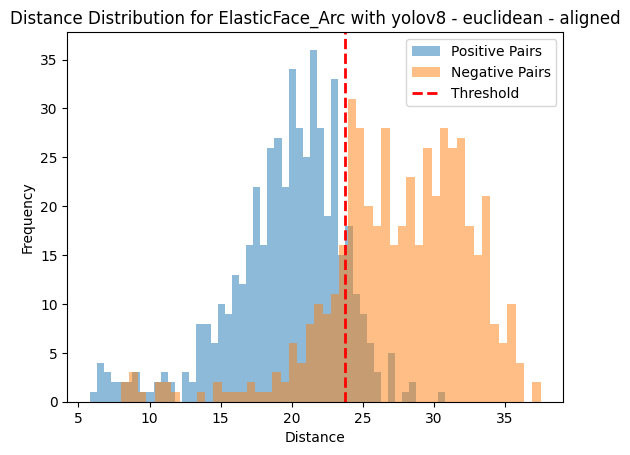

False Positives: 77
False Negatives: 57


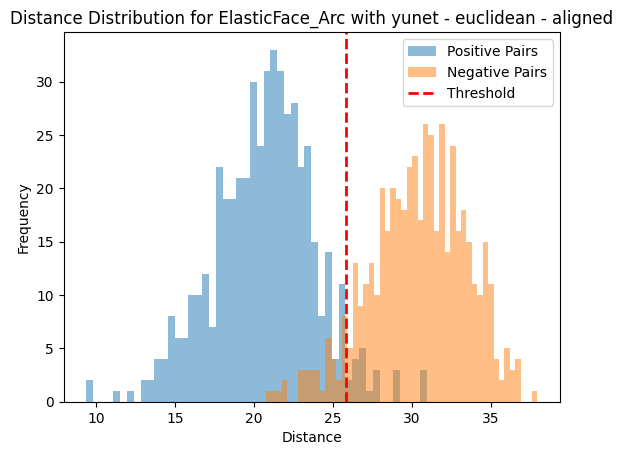

False Positives: 33
False Negatives: 21


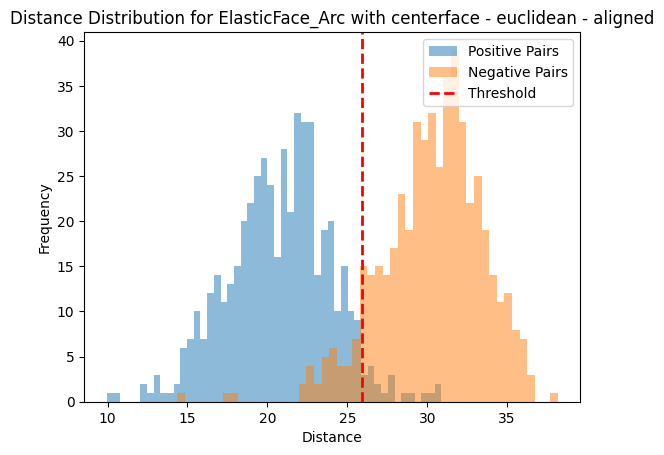

False Positives: 39
False Negatives: 18


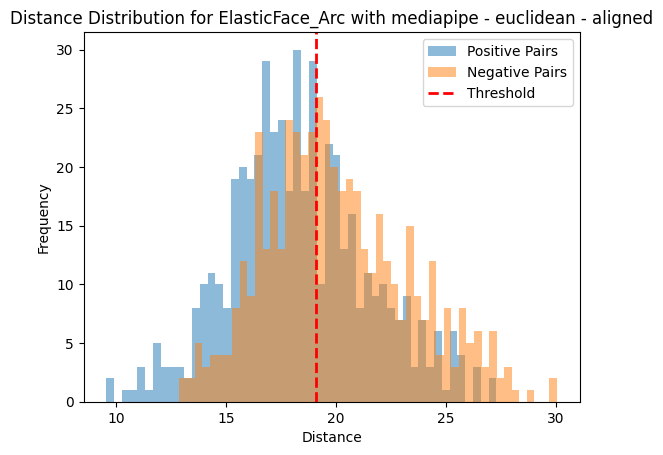

False Positives: 211
False Negatives: 181


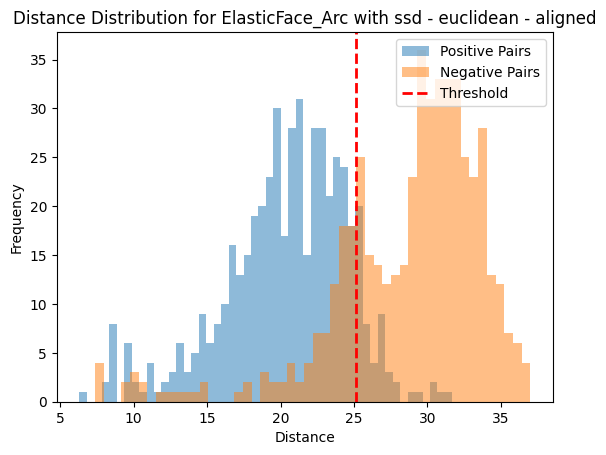

False Positives: 100
False Negatives: 46


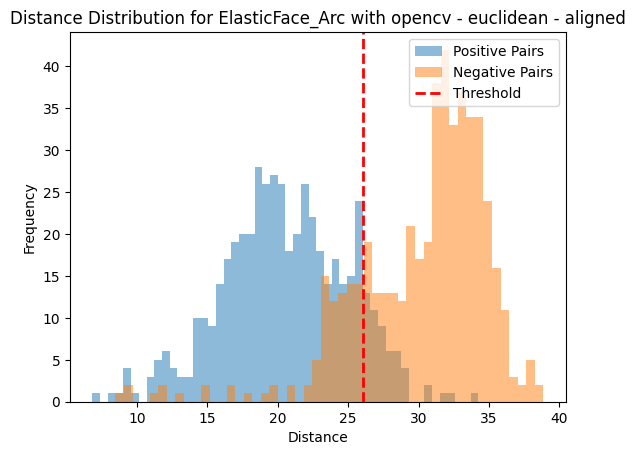

False Positives: 90
False Negatives: 52


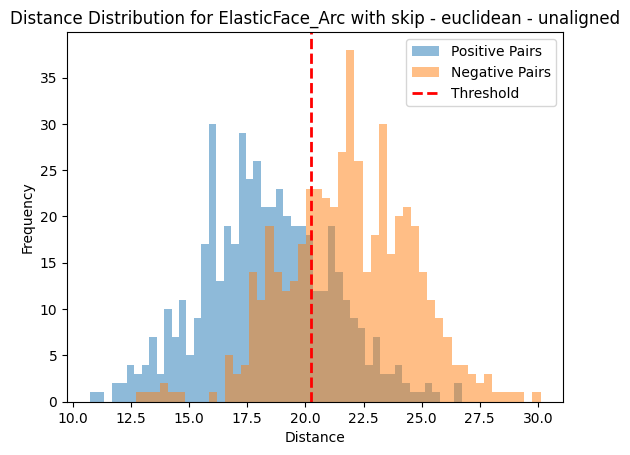

False Positives: 131
False Negatives: 117
results/pivot_euclidean_with_alignment_True.csv saved


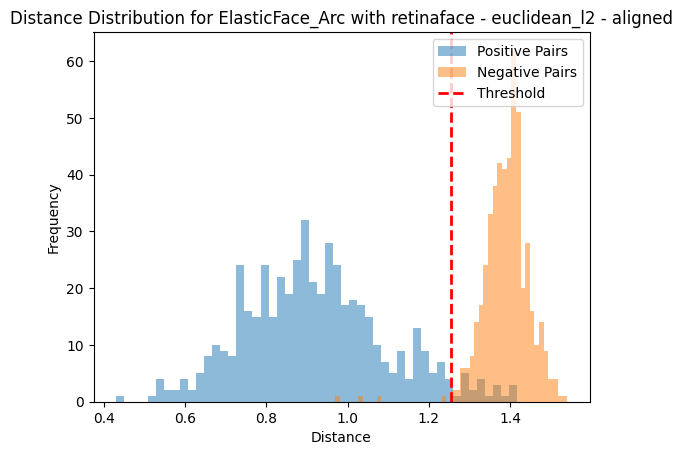

False Positives: 4
False Negatives: 20


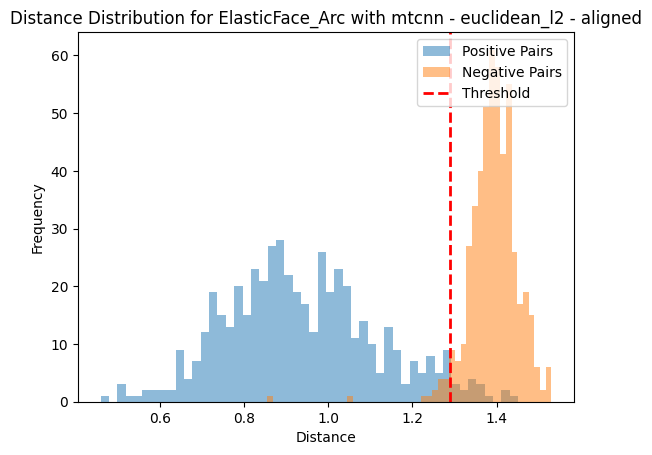

False Positives: 15
False Negatives: 16


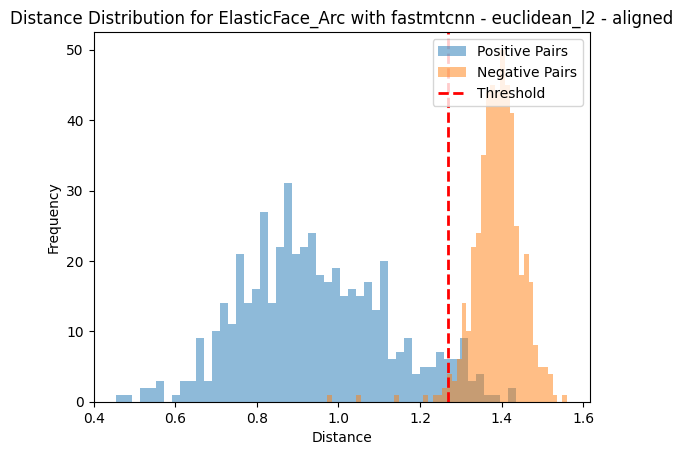

False Positives: 8
False Negatives: 28


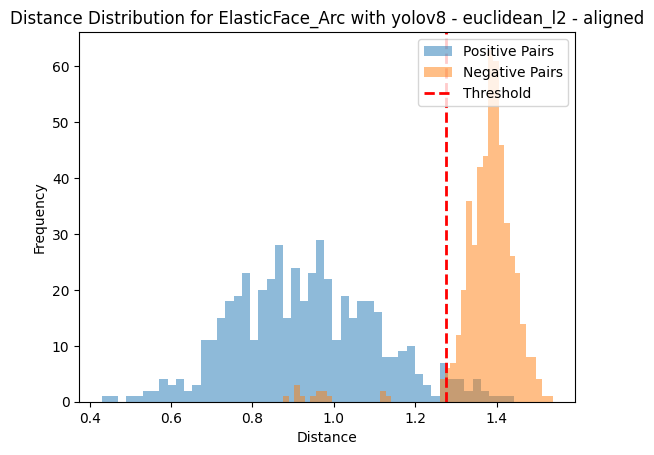

False Positives: 18
False Negatives: 20


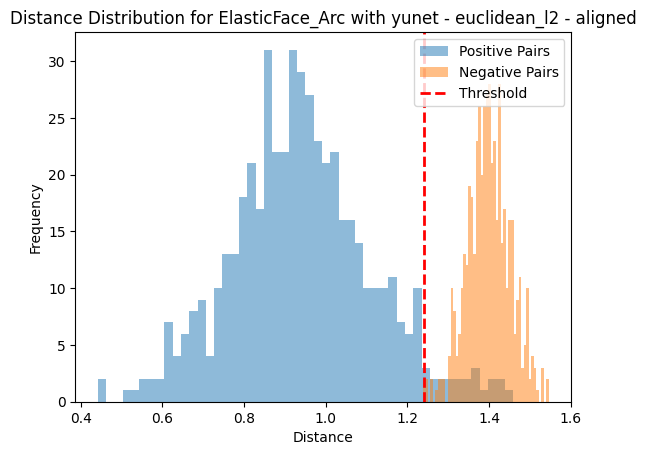

False Positives: 1
False Negatives: 19


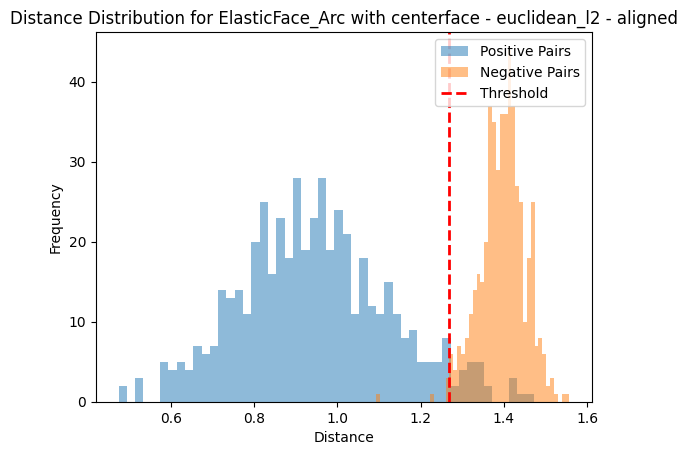

False Positives: 4
False Negatives: 23


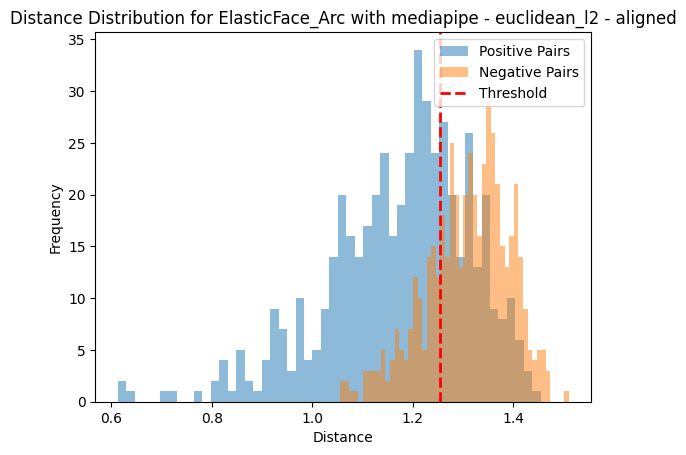

False Positives: 118
False Negatives: 152


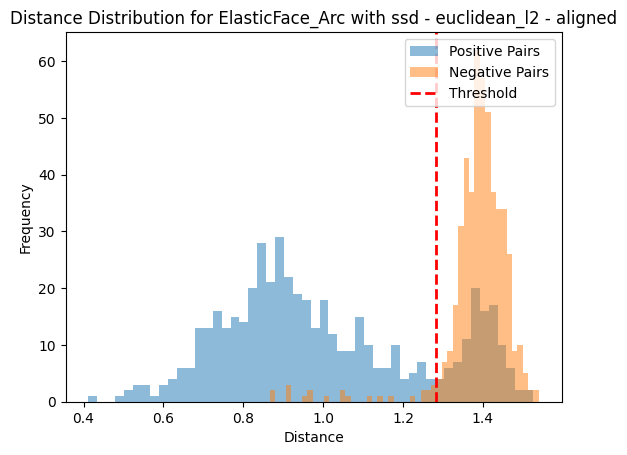

False Positives: 22
False Negatives: 101


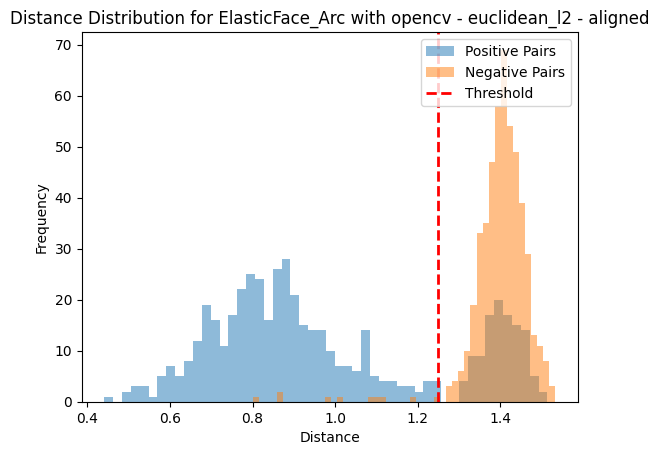

False Positives: 9
False Negatives: 113


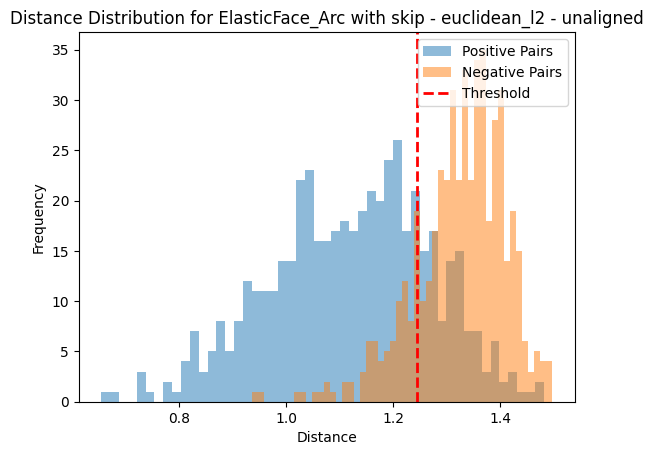

False Positives: 76
False Negatives: 108
results/pivot_euclidean_l2_with_alignment_True.csv saved


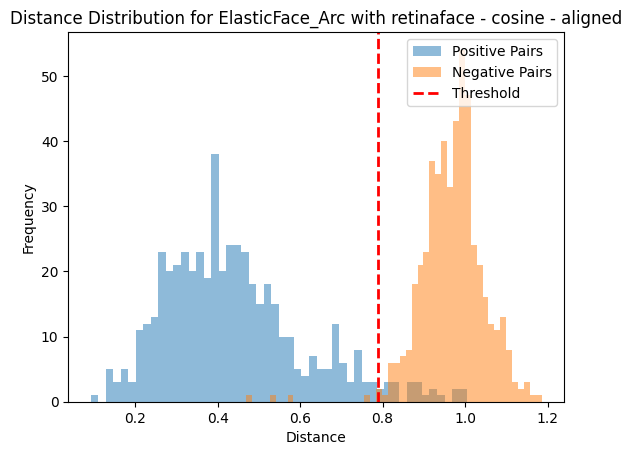

False Positives: 4
False Negatives: 20


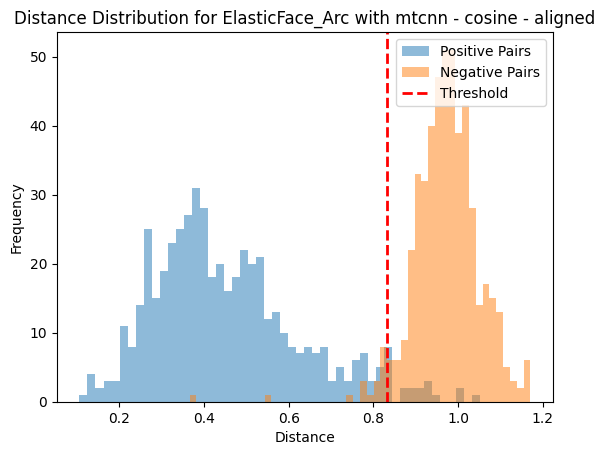

False Positives: 15
False Negatives: 16


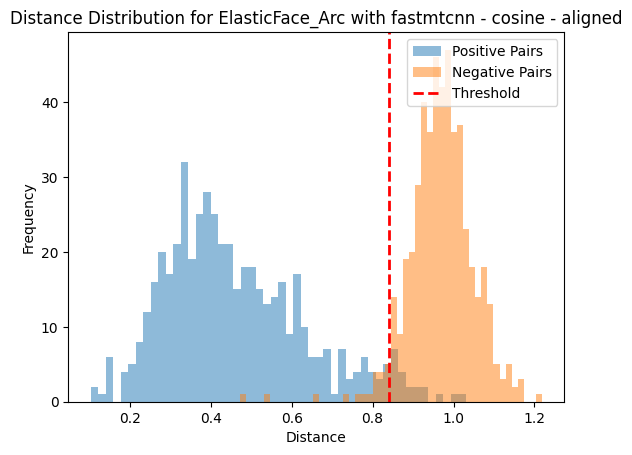

False Positives: 16
False Negatives: 20


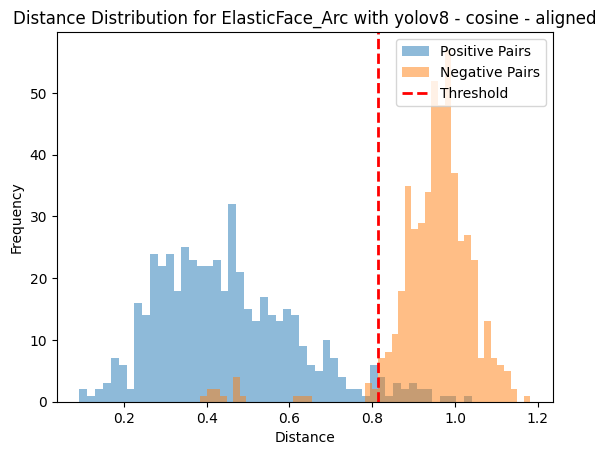

False Positives: 18
False Negatives: 20


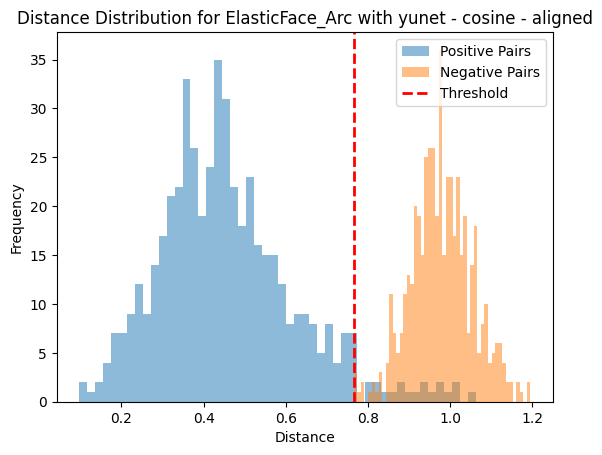

False Positives: 0
False Negatives: 20


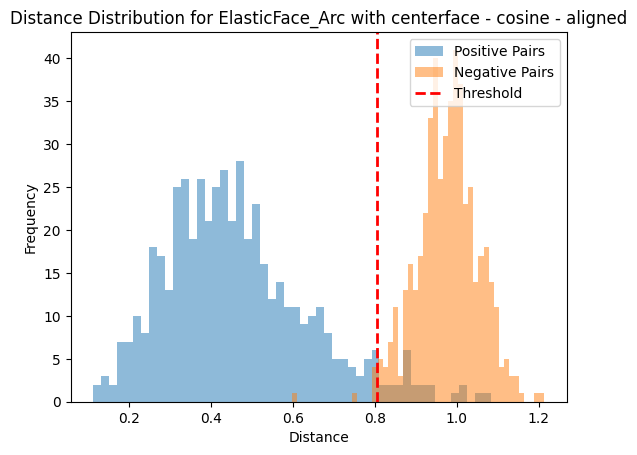

False Positives: 4
False Negatives: 23


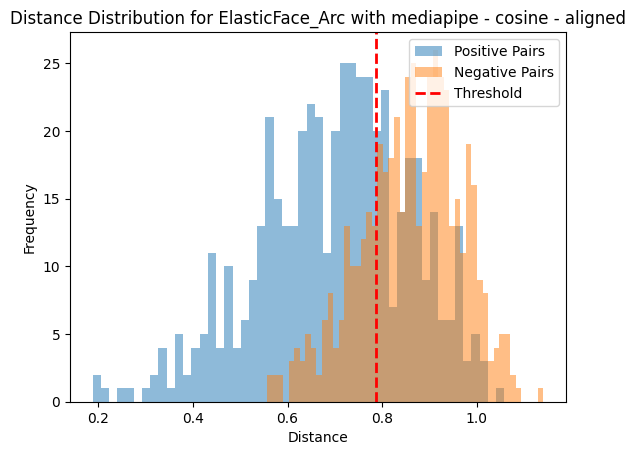

False Positives: 118
False Negatives: 152


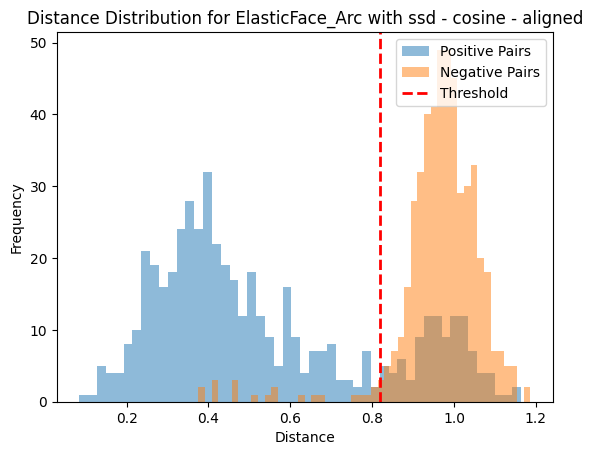

False Positives: 21
False Negatives: 102


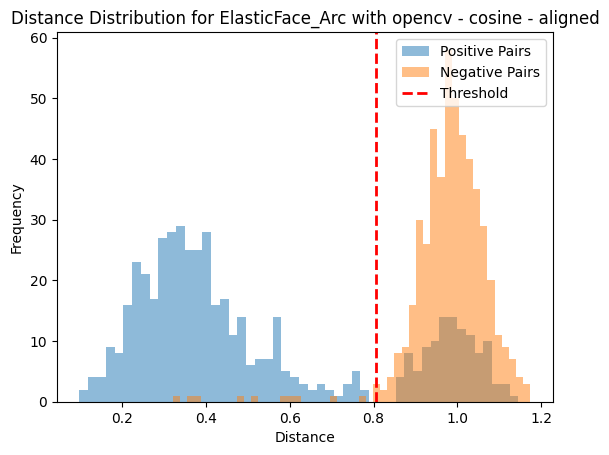

False Positives: 10
False Negatives: 112


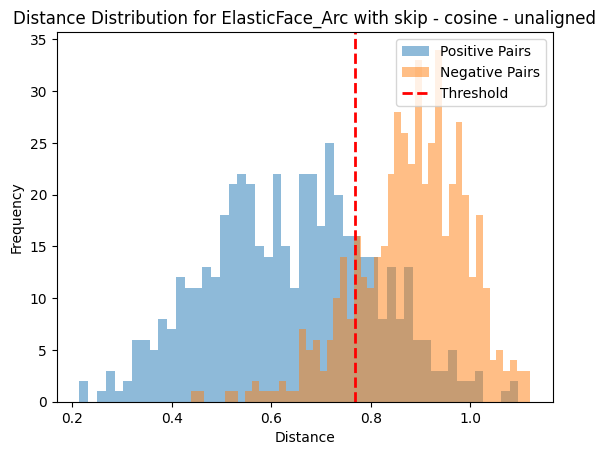

False Positives: 73
False Negatives: 111
results/pivot_cosine_with_alignment_True.csv saved


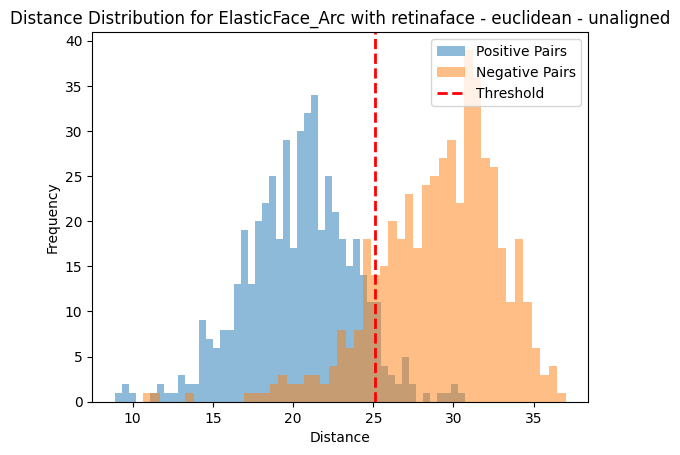

False Positives: 68
False Negatives: 29


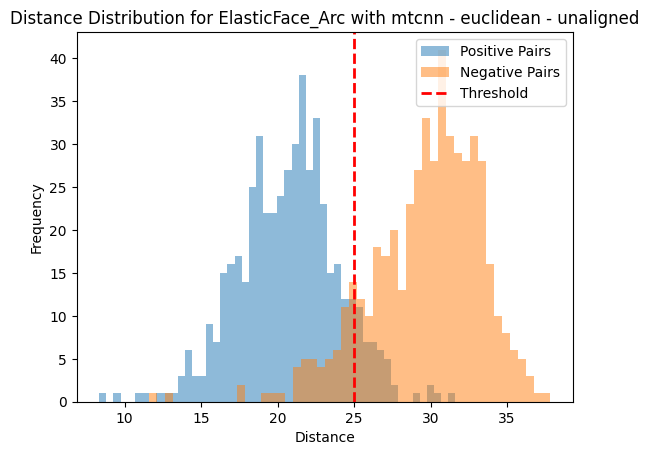

False Positives: 55
False Negatives: 44


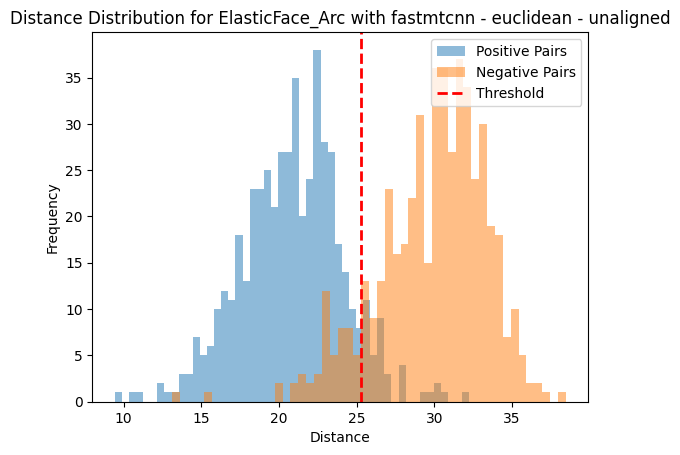

False Positives: 50
False Negatives: 39


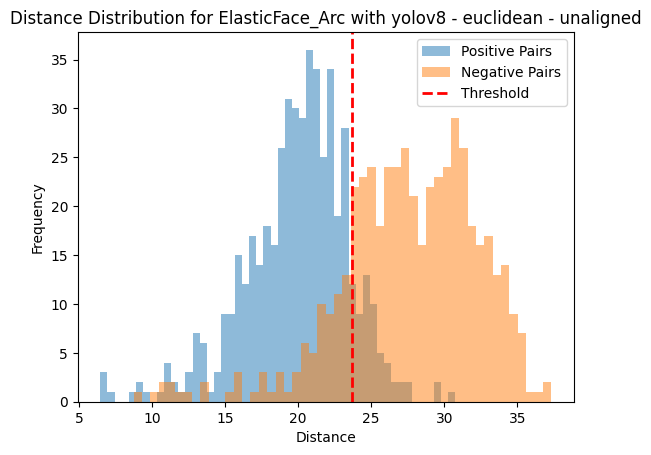

False Positives: 80
False Negatives: 55


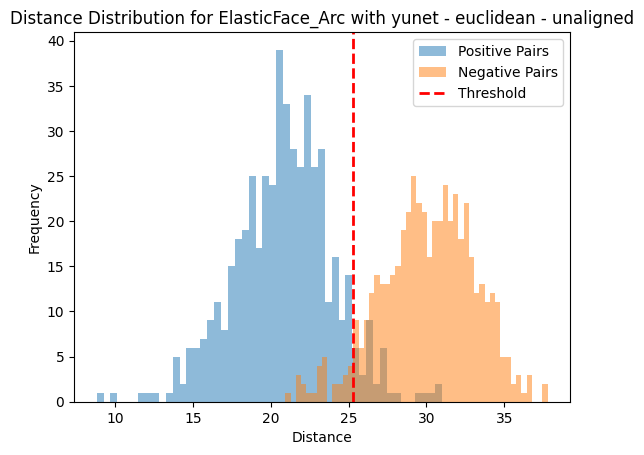

False Positives: 26
False Negatives: 33


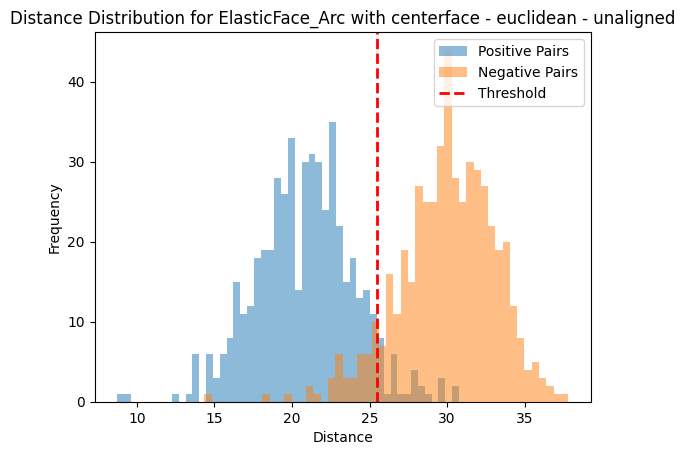

False Positives: 38
False Negatives: 28


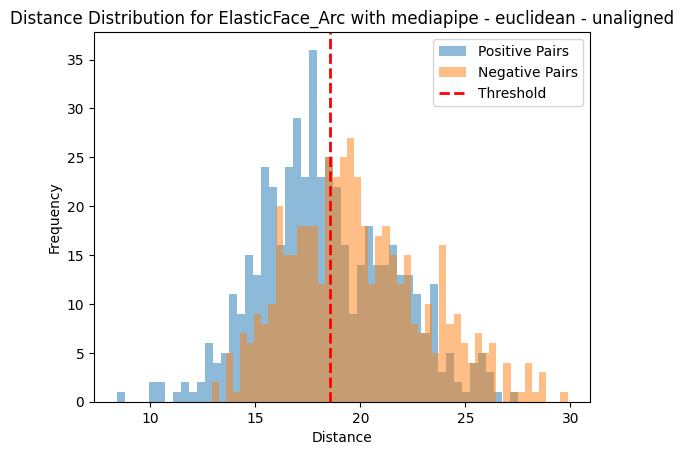

False Positives: 176
False Negatives: 212


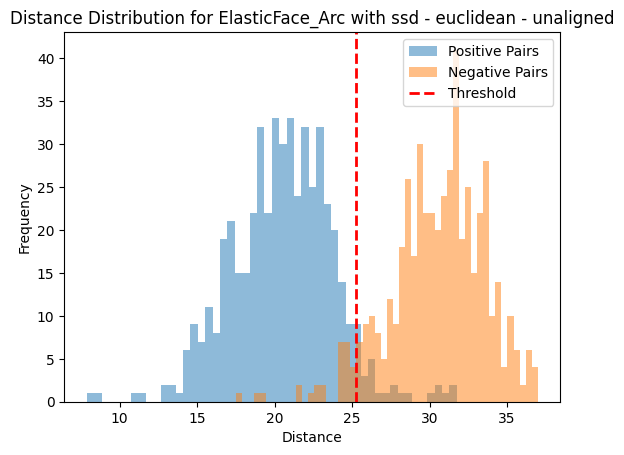

False Positives: 28
False Negatives: 23


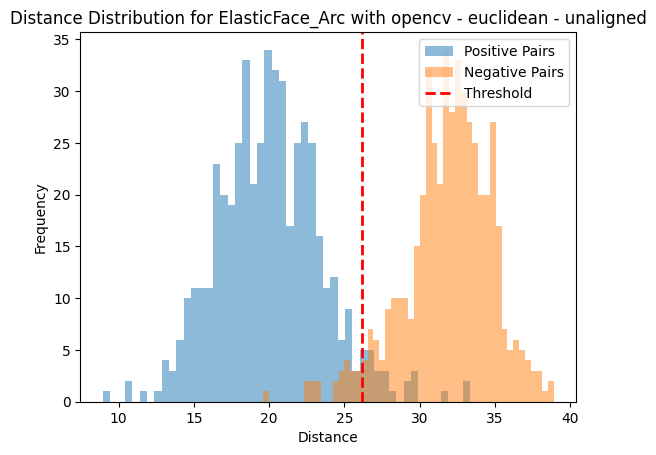

False Positives: 22
False Negatives: 22


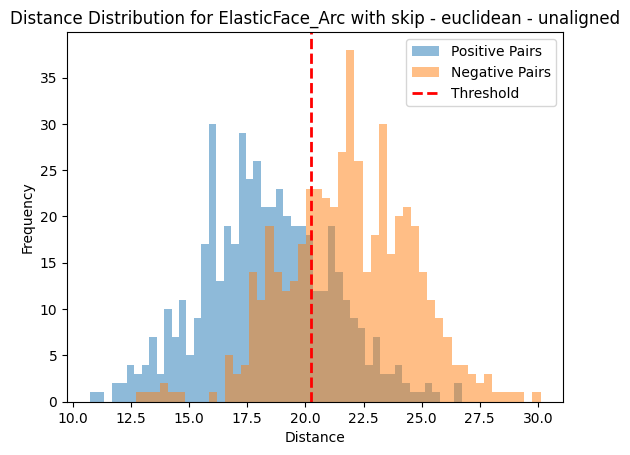

False Positives: 131
False Negatives: 117
results/pivot_euclidean_with_alignment_False.csv saved


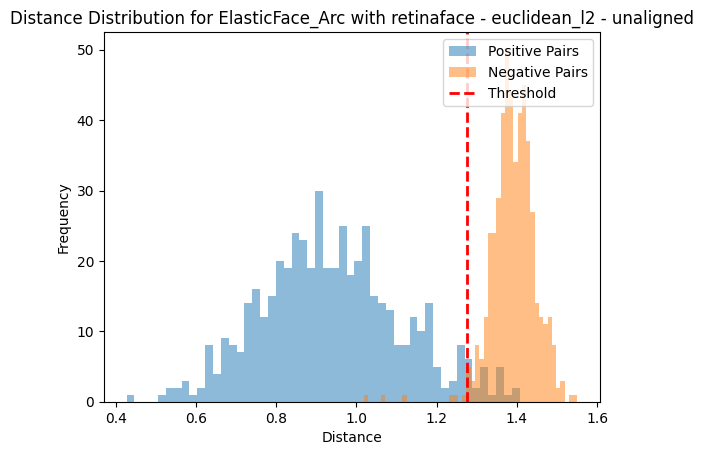

False Positives: 6
False Negatives: 20


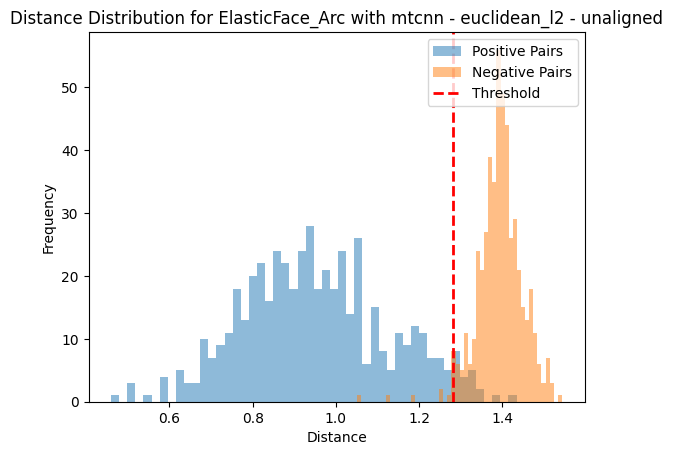

False Positives: 8
False Negatives: 19


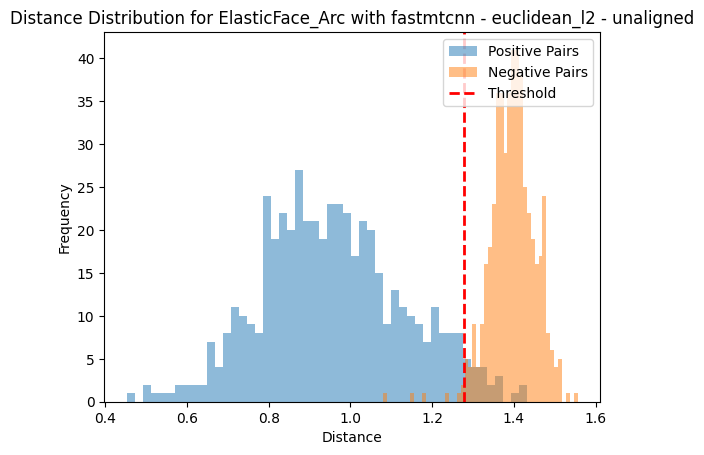

False Positives: 5
False Negatives: 21


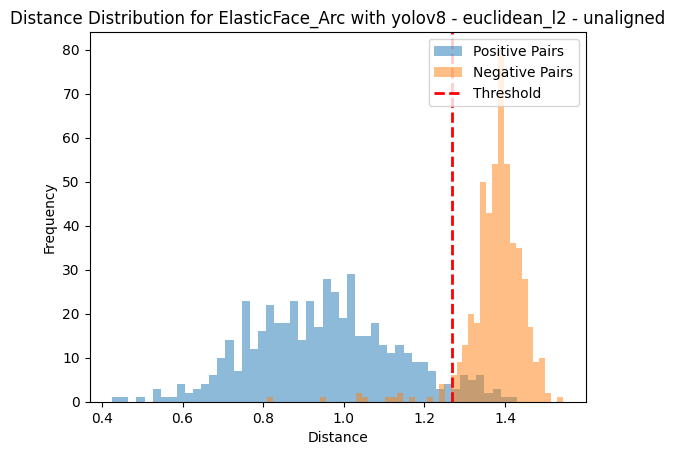

False Positives: 16
False Negatives: 27


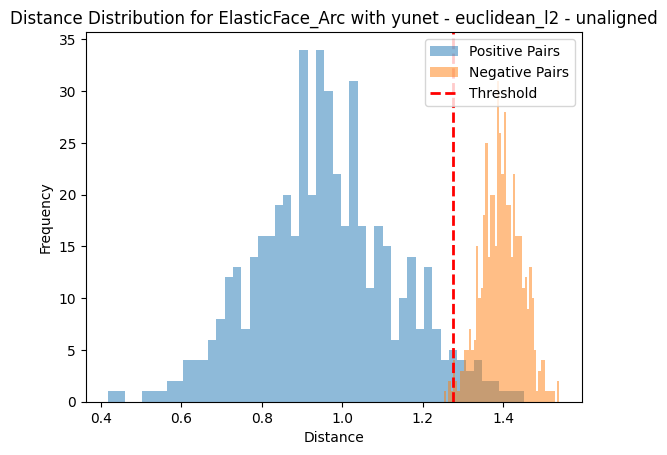

False Positives: 4
False Negatives: 19


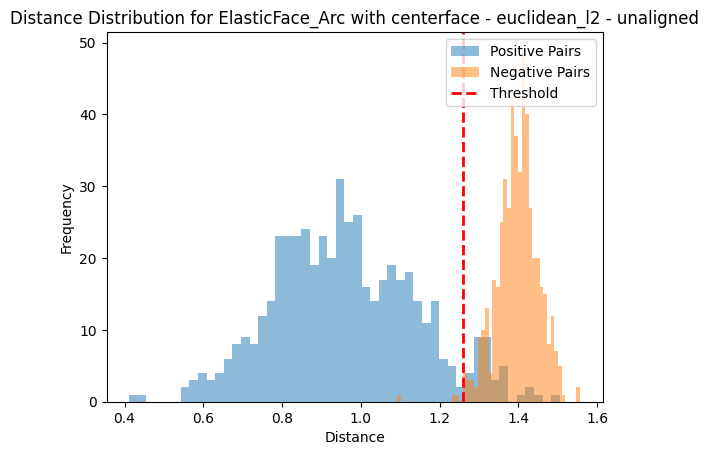

False Positives: 3
False Negatives: 35


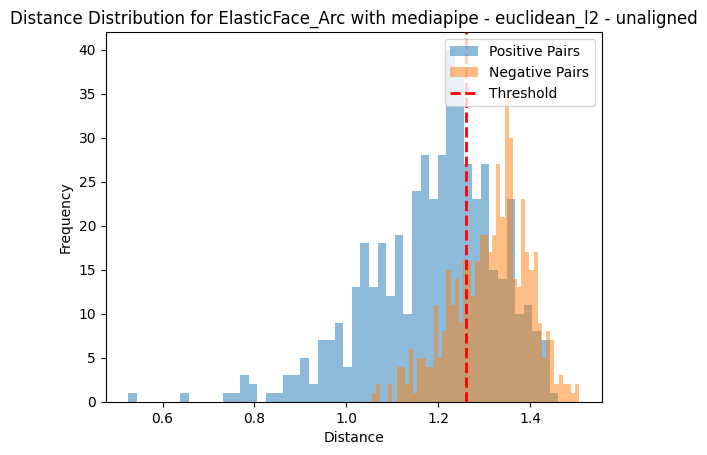

False Positives: 124
False Negatives: 153


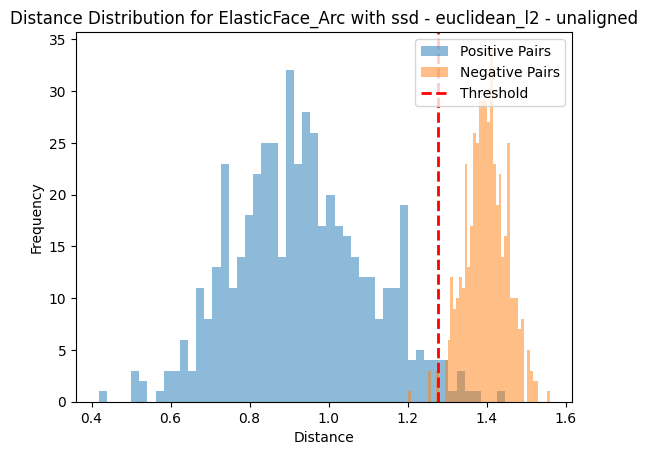

False Positives: 5
False Negatives: 11


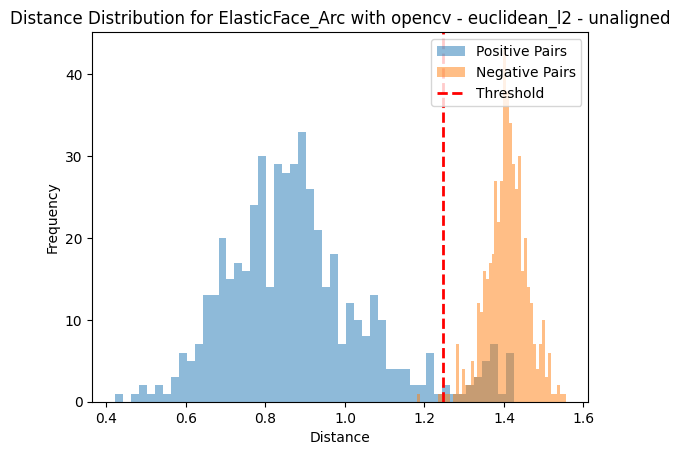

False Positives: 2
False Negatives: 27


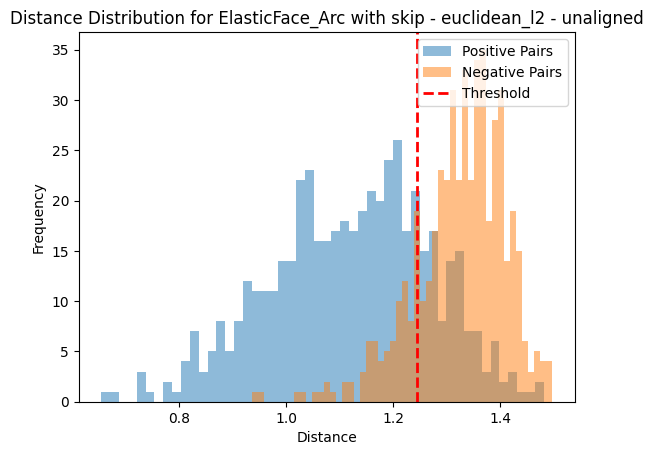

False Positives: 76
False Negatives: 108
results/pivot_euclidean_l2_with_alignment_False.csv saved


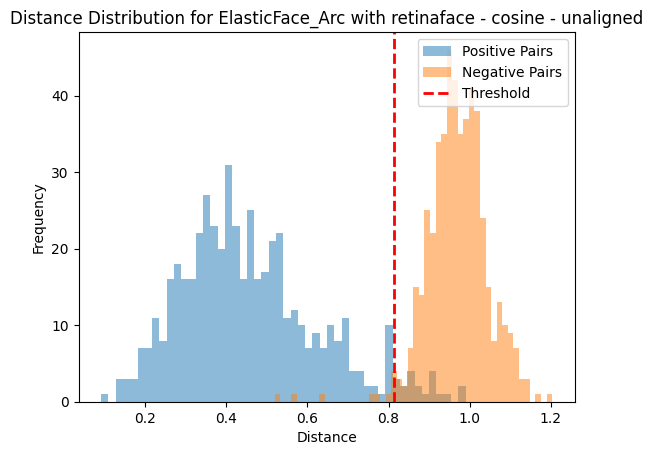

False Positives: 6
False Negatives: 20


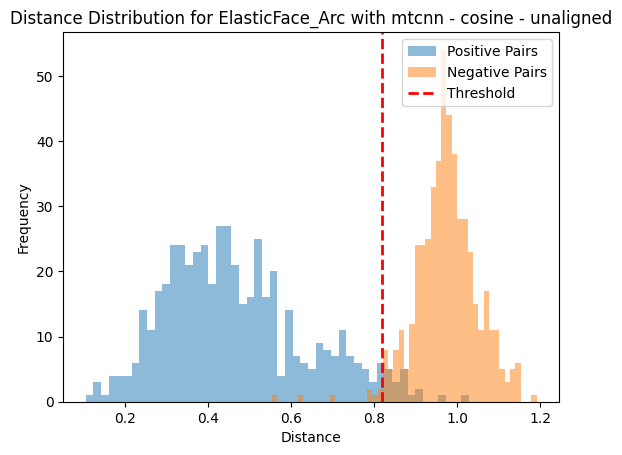

False Positives: 6
False Negatives: 21


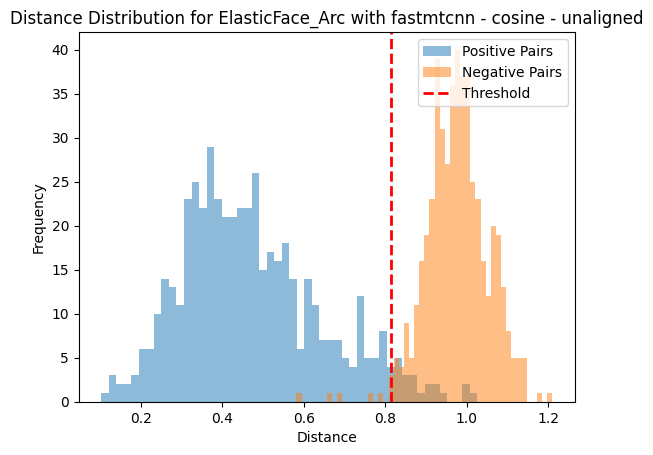

False Positives: 5
False Negatives: 21


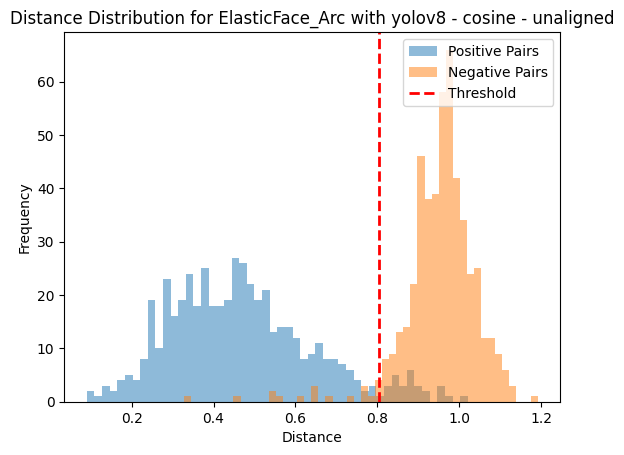

False Positives: 15
False Negatives: 28


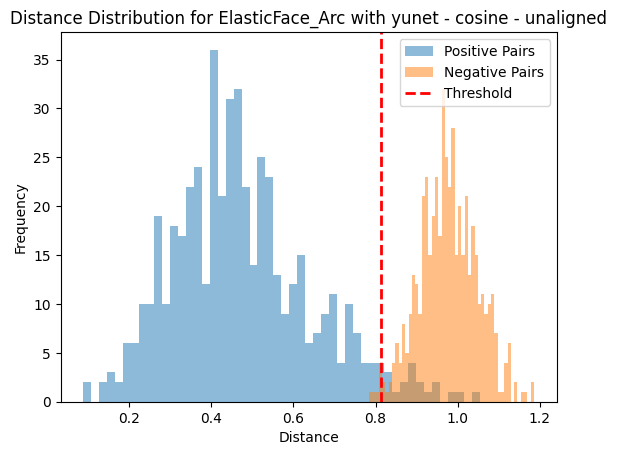

False Positives: 4
False Negatives: 19


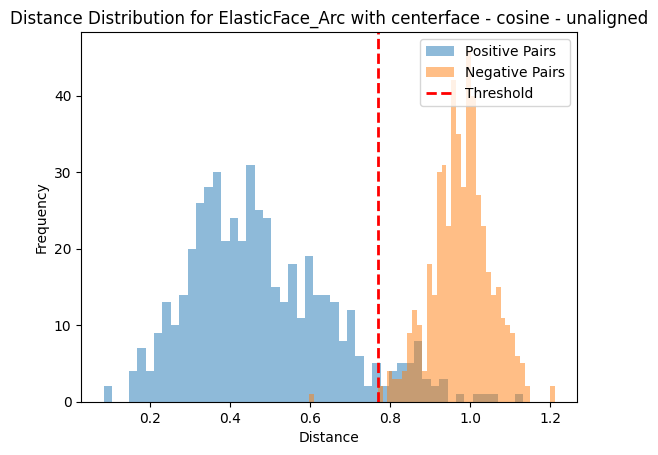

False Positives: 1
False Negatives: 37


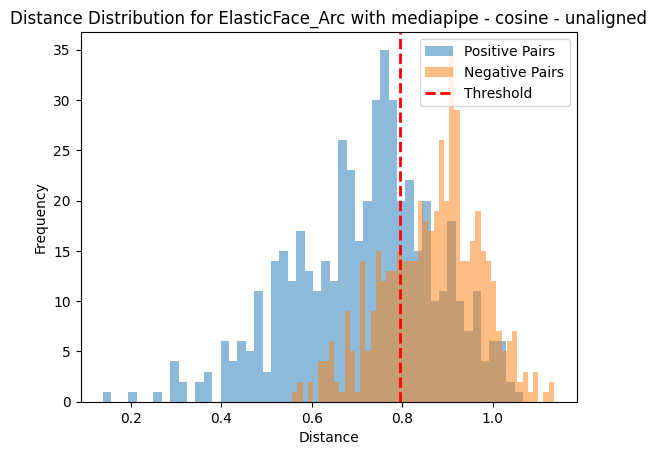

False Positives: 124
False Negatives: 153


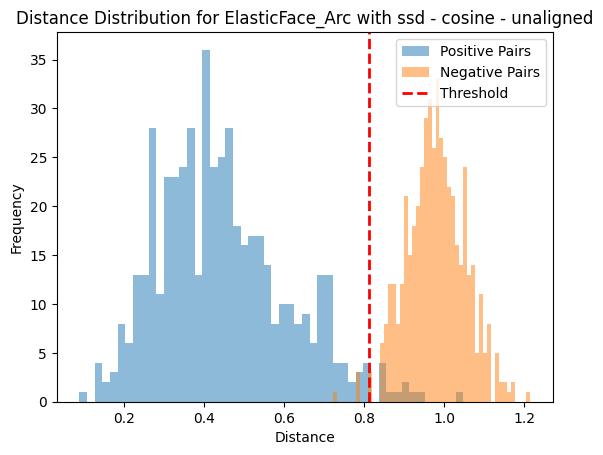

False Positives: 4
False Negatives: 12


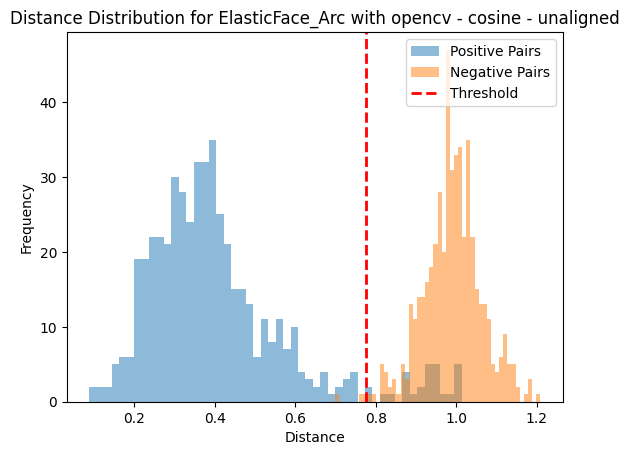

False Positives: 2
False Negatives: 27


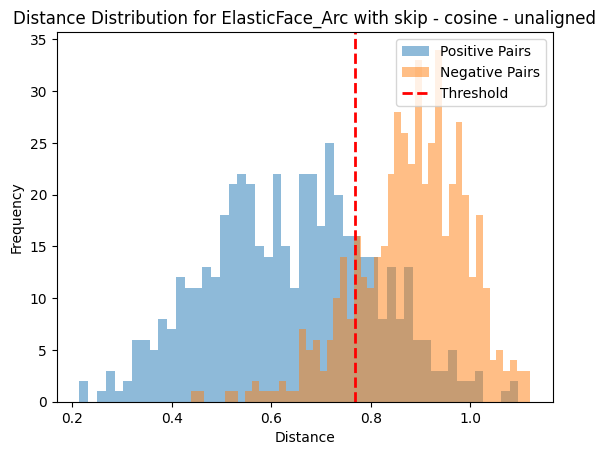

False Positives: 73
False Negatives: 111
results/pivot_cosine_with_alignment_False.csv saved


In [11]:
for is_aligned in alignment:
    for distance_metric in metrics:

        current_df = base_df.copy()
        current_df["threshold"] = 0.0  # Initialize a new column for thresholds

        target_file = f"results/pivot_{distance_metric}_with_alignment_{is_aligned}.csv"
        if os.path.exists(target_file):
            continue

        for model_name in models:
            for detector_backend in detectors:

                align = "aligned" if is_aligned is True else "unaligned"

                if detector_backend == "skip" and is_aligned is True:
                    # Alignment is not possible for a skipped detector configuration
                    align = "unaligned"

                source_file = f"outputs/test/{model_name}_{detector_backend}_{distance_metric}_{align}.csv"
                df = pd.read_csv(source_file)

                positive_mean = df[(df["actuals"] == True) | (df["actuals"] == 1)]["distances"].mean()
                negative_mean = df[(df["actuals"] == False) | (df["actuals"] == 0)]["distances"].mean()

                distances = sorted(df["distances"].values.tolist())

                items = []
                for i, distance in enumerate(distances):
                    if distance >= positive_mean and distance <= negative_mean:
                        sandbox_df = df.copy()
                        sandbox_df["predictions"] = False
                        idx = sandbox_df[sandbox_df["distances"] < distance].index
                        sandbox_df.loc[idx, "predictions"] = True

                        actuals = sandbox_df.actuals.values.tolist()
                        predictions = sandbox_df.predictions.values.tolist()
                        accuracy = 100 * accuracy_score(actuals, predictions)
                        items.append((distance, accuracy))

                pivot_df = pd.DataFrame(items, columns=["distance", "accuracy"])
                pivot_df = pivot_df.sort_values(by=["accuracy"], ascending=False)
                threshold = pivot_df.iloc[0]["distance"]
                accuracy = pivot_df.iloc[0]["accuracy"]

                # Store accuracy and threshold in current_df
                current_df.at[detector_backend, model_name] = round(accuracy, 1)
                current_df.at[detector_backend, "threshold"] = round(threshold, 4)

                # Visualization
                positive_distances = df[df["actuals"] == 1]["distances"]
                negative_distances = df[df["actuals"] == 0]["distances"]

                plt.hist(positive_distances, bins=50, alpha=0.5, label='Positive Pairs')
                plt.hist(negative_distances, bins=50, alpha=0.5, label='Negative Pairs')
                plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='Threshold')
                plt.xlabel('Distance')
                plt.ylabel('Frequency')
                plt.legend(loc='upper right')
                plt.title(f'Distance Distribution for {model_name} with {detector_backend} - {distance_metric} - {align}')
                plt.show()

                # Analysis
                false_positives = df[(df["actuals"] == 0) & (df["distances"] < threshold)]
                false_negatives = df[(df["actuals"] == 1) & (df["distances"] > threshold)]

                print(f"False Positives: {len(false_positives)}")
                print(f"False Negatives: {len(false_negatives)}")

        current_df.to_csv(target_file)
        print(f"{target_file} saved")

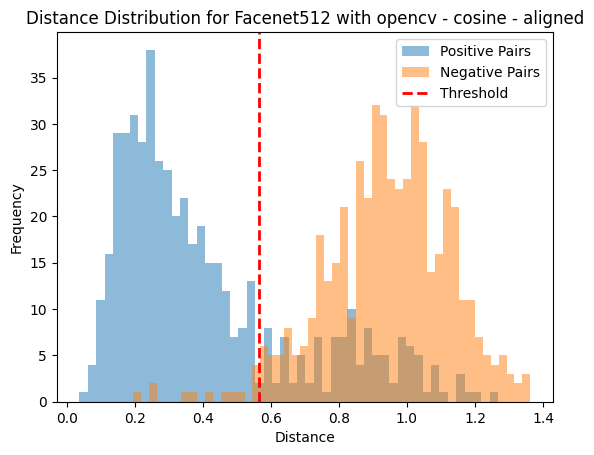

False Positives for Facenet512/opencv/cosine/aligned: 11
False Negatives for Facenet512/opencv/cosine/aligned: 113


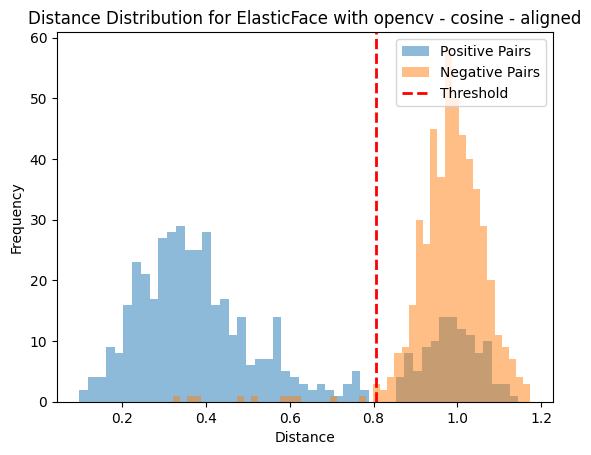

False Positives for ElasticFace/opencv/cosine/aligned: 10
False Negatives for ElasticFace/opencv/cosine/aligned: 112
results/pivot_cosine_with_alignment_True.csv saved


In [21]:
for is_aligned in alignment:
    for distance_metric in metrics:

        current_df = base_df.copy()
        current_df["threshold"] = 0.0  # Initialize a new column for thresholds

        target_file = f"results/pivot_{distance_metric}_with_alignment_{is_aligned}.csv"
        if os.path.exists(target_file):
            continue

        for model_name in models:
            for detector_backend in detectors:

                align = "aligned" if is_aligned is True else "unaligned"

                if detector_backend == "skip" and is_aligned is True:
                    # Alignment is not possible for a skipped detector configuration
                    align = "unaligned"

                source_file = f"outputs/test/{model_name}_{detector_backend}_{distance_metric}_{align}.csv"
                df = pd.read_csv(source_file)

                positive_mean = df[(df["actuals"] == True) | (df["actuals"] == 1)]["distances"].mean()
                negative_mean = df[(df["actuals"] == False) | (df["actuals"] == 0)]["distances"].mean()

                distances = sorted(df["distances"].values.tolist())

                items = []
                for i, distance in enumerate(distances):
                    if distance >= positive_mean and distance <= negative_mean:
                        sandbox_df = df.copy()
                        sandbox_df["predictions"] = False
                        idx = sandbox_df[sandbox_df["distances"] < distance].index
                        sandbox_df.loc[idx, "predictions"] = True

                        actuals = sandbox_df.actuals.values.tolist()
                        predictions = sandbox_df.predictions.values.tolist()
                        accuracy = 100 * accuracy_score(actuals, predictions)
                        items.append((distance, accuracy))

                pivot_df = pd.DataFrame(items, columns=["distance", "accuracy"])
                pivot_df = pivot_df.sort_values(by=["accuracy"], ascending=False)
                threshold = pivot_df.iloc[0]["distance"]
                accuracy = pivot_df.iloc[0]["accuracy"]

                # Store accuracy and threshold in current_df
                current_df.at[detector_backend, model_name] = round(accuracy, 1)
                current_df.at[detector_backend, "threshold"] = round(threshold, 4)

                # Identify pairs going beyond the threshold
                false_positive_pairs = df[(df["actuals"] == 0) & (df["distances"] < threshold)]
                false_negative_pairs = df[(df["actuals"] == 1) & (df["distances"] > threshold)]

                false_positive_pairs_info = false_positive_pairs.assign(pair_index=false_positive_pairs.index)
                false_negative_pairs_info = false_negative_pairs.assign(pair_index=false_negative_pairs.index)

                # Save to CSV for analysis
                false_positive_pairs_info.to_csv(f"results/false_positive_pairs_{model_name}_{detector_backend}_{distance_metric}_{align}.csv", index=False)
                false_negative_pairs_info.to_csv(f"results/false_negative_pairs_{model_name}_{detector_backend}_{distance_metric}_{align}.csv", index=False)

                # Visualization
                positive_distances = df[df["actuals"] == 1]["distances"]
                negative_distances = df[df["actuals"] == 0]["distances"]

                plt.hist(positive_distances, bins=50, alpha=0.5, label='Positive Pairs')
                plt.hist(negative_distances, bins=50, alpha=0.5, label='Negative Pairs')
                plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='Threshold')
                plt.xlabel('Distance')
                plt.ylabel('Frequency')
                plt.legend(loc='upper right')
                plt.title(f'Distance Distribution for {model_name} with {detector_backend} - {distance_metric} - {align}')
                plt.show()

                # Analysis
                print(f"False Positives for {model_name}/{detector_backend}/{distance_metric}/{align}: {len(false_positive_pairs)}")
                print(f"False Negatives for {model_name}/{detector_backend}/{distance_metric}/{align}: {len(false_negative_pairs)}")

        current_df.to_csv(target_file)
        print(f"{target_file} saved")

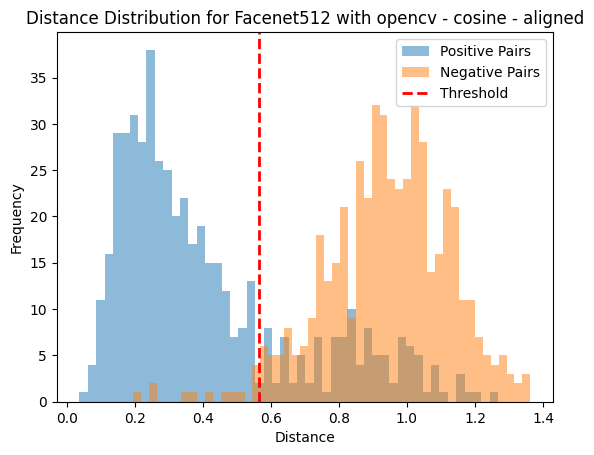

False Positives: 11
False Negatives: 113


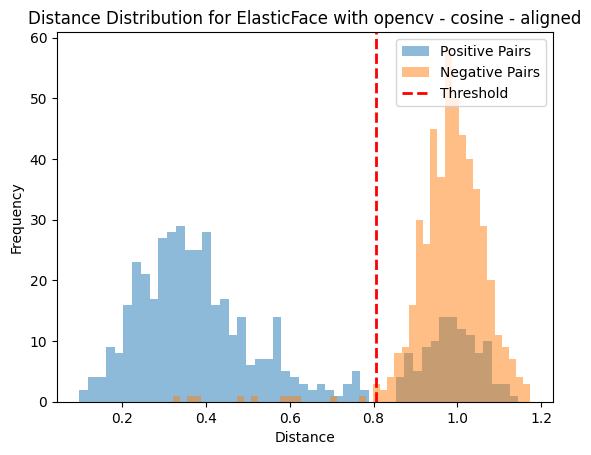

False Positives: 10
False Negatives: 112
results/pivot_cosine_with_alignment_True.csv saved


In [11]:
for is_aligned in alignment:
    for distance_metric in metrics:

        current_df = base_df.copy()
        current_df["threshold"] = 0.0  # Initialize a new column for thresholds

        target_file = f"results/pivot_{distance_metric}_with_alignment_{is_aligned}.csv"
        if os.path.exists(target_file):
            continue

        for model_name in models:
            for detector_backend in detectors:

                align = "aligned" if is_aligned is True else "unaligned"

                if detector_backend == "skip" and is_aligned is True:
                    # Alignment is not possible for a skipped detector configuration
                    align = "unaligned"

                source_file = f"outputs/test/{model_name}_{detector_backend}_{distance_metric}_{align}.csv"
                df = pd.read_csv(source_file)

                positive_mean = df[(df["actuals"] == True) | (df["actuals"] == 1)]["distances"].mean()
                negative_mean = df[(df["actuals"] == False) | (df["actuals"] == 0)]["distances"].mean()

                distances = sorted(df["distances"].values.tolist())

                items = []
                for i, distance in enumerate(distances):
                    if distance >= positive_mean and distance <= negative_mean:
                        sandbox_df = df.copy()
                        sandbox_df["predictions"] = False
                        idx = sandbox_df[sandbox_df["distances"] < distance].index
                        sandbox_df.loc[idx, "predictions"] = True

                        actuals = sandbox_df.actuals.values.tolist()
                        predictions = sandbox_df.predictions.values.tolist()
                        accuracy = 100 * accuracy_score(actuals, predictions)
                        items.append((distance, accuracy))

                pivot_df = pd.DataFrame(items, columns=["distance", "accuracy"])
                pivot_df = pivot_df.sort_values(by=["accuracy"], ascending=False)
                threshold = pivot_df.iloc[0]["distance"]
                accuracy = pivot_df.iloc[0]["accuracy"]

                # Store accuracy and threshold in current_df
                current_df.at[detector_backend, model_name] = round(accuracy, 1)
                current_df.at[detector_backend, "threshold"] = round(threshold, 4)

                # Visualization
                positive_distances = df[df["actuals"] == 1]["distances"]
                negative_distances = df[df["actuals"] == 0]["distances"]

                plt.hist(positive_distances, bins=50, alpha=0.5, label='Positive Pairs')
                plt.hist(negative_distances, bins=50, alpha=0.5, label='Negative Pairs')
                plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='Threshold')
                plt.xlabel('Distance')
                plt.ylabel('Frequency')
                plt.legend(loc='upper right')
                plt.title(f'Distance Distribution for {model_name} with {detector_backend} - {distance_metric} - {align}')
                plt.show()

                # Analysis
                false_positives = df[(df["actuals"] == 0) & (df["distances"] < threshold)]
                false_negatives = df[(df["actuals"] == 1) & (df["distances"] > threshold)]

                print(f"False Positives: {len(false_positives)}")
                print(f"False Negatives: {len(false_negatives)}")

        current_df.to_csv(target_file)
        print(f"{target_file} saved")

In [25]:
# for is_aligned in alignment:
#     for distance_metric in metrics:

#         current_df = base_df.copy()
#         current_df["threshold"] = 0.0  # Initialize a new column for thresholds

        
#         target_file = f"results/pivot_{distance_metric}_with_alignment_{is_aligned}.csv"
#         if os.path.exists(target_file):
#             continue
        
#         for model_name in models:
#             for detector_backend in detectors:

#                 align = "aligned" if is_aligned is True else "unaligned"

#                 if detector_backend == "skip" and is_aligned is True:
#                     # Alignment is not possible for a skipped detector configuration
#                     align = "unaligned"

#                 source_file = f"outputs/test/{model_name}_{detector_backend}_{distance_metric}_{align}.csv"
#                 df = pd.read_csv(source_file)
                  
#                 positive_mean = df[(df["actuals"] == True) | (df["actuals"] == 1)]["distances"].mean()
#                 negative_mean = df[(df["actuals"] == False) | (df["actuals"] == 0)]["distances"].mean()

#                 distances = sorted(df["distances"].values.tolist())

#                 items = []
#                 for i, distance in enumerate(distances):
#                     if distance >= positive_mean and distance <= negative_mean:
#                         sandbox_df = df.copy()
#                         sandbox_df["predictions"] = False
#                         idx = sandbox_df[sandbox_df["distances"] < distance].index
#                         sandbox_df.loc[idx, "predictions"] = True

#                         actuals = sandbox_df.actuals.values.tolist()
#                         predictions = sandbox_df.predictions.values.tolist()
#                         accuracy = 100*accuracy_score(actuals, predictions)
#                         items.append((distance, accuracy))

#                 pivot_df = pd.DataFrame(items, columns = ["distance", "accuracy"])
#                 pivot_df = pivot_df.sort_values(by = ["accuracy"], ascending = False)
#                 threshold = pivot_df.iloc[0]["distance"]
#                 print(f"threshold for {model_name}/{detector_backend} is {threshold}")
#                 accuracy = pivot_df.iloc[0]["accuracy"]

#                 # print(source_file, round(accuracy, 1))
#                 current_df.at[detector_backend, model_name] = round(accuracy, 1)
#                 current_df.at[detector_backend, "threshold"] = round(threshold, 4)
#                 # thresholds[f"{model_name}_{detector_backend}"] = round(threshold, 4)
        

        
#         current_df.to_csv(target_file)
#         print(f"{target_file} saved")

In [16]:
# image = "C:/Users/prath/Downloads/lfwe/test/testfind.jpg"
# database = "C:/Users/prath/Downloads/lfwe/test"
# findobj = DeepFace.find(image, database, model_name = "ElasticFace", enforce_detection= False)

24-06-13 01:27:05 - Found 2001 newly added image(s), 0 removed image(s), 0 replaced image(s).


Finding representations: 100%|█████████████████████████████████████████████████████| 2001/2001 [26:27<00:00,  1.26it/s]


24-06-13 01:53:33 - There are now 2124 representations in ds_model_elasticface_detector_opencv_aligned_normalization_base_expand_0.pkl
24-06-13 01:53:33 - Searching C:/Users/prath/Downloads/lfwe/test/testfind.jpg in 2124 length datastore
24-06-13 01:53:35 - find function duration 1591.127289056778 seconds


In [17]:
# findobj

[                                          identity  \
 0  C:/Users/prath/Downloads/lfwe/test\testfind.jpg   
 1     C:/Users/prath/Downloads/lfwe/test\518_1.jpg   
 2       C:/Users/prath/Downloads/lfwe/test\4_1.jpg   
 
                                        hash  target_x  target_y  target_w  \
 0  fac145397f1a4be73cb9f5ba3dd91ff6379f4714         0         0       419   
 1  8a112be2a954efcebe2cc73101ec7f8195599f36       136       137       231   
 2  55ceb170c0d64532c0f29531c3c2911881270275       136       137       231   
 
    target_h  source_x  source_y  source_w  source_h  threshold  distance  
 0       556         0         0       419       556        0.4  0.000000  
 1       231         0         0       419       556        0.4  0.269716  
 2       231         0         0       419       556        0.4  0.269716  ]